# Projeto Dados Strava

## Pegando dados do GPX do Strava

Vamos pegar os dados do percurso da prova LaMision 35km

In [1]:
import gpxpy
import gpxpy.gpx

import pandas as pd
import numpy as np
import haversine as hs
import matplotlib.pyplot as plt
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [2]:
with open('COROS - LA MISION - 35km.gpx', 'r', encoding='utf-8') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

In [15]:
print(gpx)

GPX(tracks=[GPXTrack(name='COROS - LA MISION - 35km', segments=[GPXTrackSegment(points=[...])])])


In [4]:
gpx.get_track_points_no()

18806

In [5]:
gpx.get_elevation_extremes()

MinimumMaximum(minimum=915.0, maximum=2217.0)

- Aqui temos a altitude menor (altitude_min = 915) e o máximo de altitude(altitude_max = 2217)

In [7]:
gpx.get_uphill_downhill()

UphillDownhill(uphill=2772.1000000000013, downhill=2775.1000000000013)

- Aqui temos um ganho de elevação de 2772 m

In [16]:
gpx.tracks[0].segments[0].points[:10]

[GPXTrackPoint(-22.3905289, -44.9661817, elevation=922.0),
 GPXTrackPoint(-22.3905414, -44.9661728, elevation=922.0),
 GPXTrackPoint(-22.3905539, -44.9661641, elevation=922.0),
 GPXTrackPoint(-22.3905742, -44.9661552, elevation=921.0),
 GPXTrackPoint(-22.3905946, -44.9661465, elevation=921.0),
 GPXTrackPoint(-22.3906218, -44.9661392, elevation=921.0),
 GPXTrackPoint(-22.3906491, -44.9661319, elevation=921.0),
 GPXTrackPoint(-22.3906807, -44.966123, elevation=921.0),
 GPXTrackPoint(-22.3907123, -44.9661142, elevation=921.0),
 GPXTrackPoint(-22.3907472, -44.9661053, elevation=921.0)]

In [17]:
route_info = []
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            route_info.append({
                    'latitude': point.latitude,
                    'longitude': point.longitude,
                    'elevacao': point.elevation
            })
            
route_df = pd.DataFrame(route_info)
route_df.head(10)

,latitude,longitude,elevacao
0,-22.390529,-44.966182,922.0
1,-22.390541,-44.966173,922.0
2,-22.390554,-44.966164,922.0
3,-22.390574,-44.966155,921.0
4,-22.390595,-44.966147,921.0
5,-22.390622,-44.966139,921.0
6,-22.390649,-44.966132,921.0
7,-22.390681,-44.966123,921.0
8,-22.390712,-44.966114,921.0
9,-22.390747,-44.966105,921.0


- Aqui podemos ver que em nossos dados temos um mesmo lat/long com diferentes 'elevações'. Então vamos agrupar e remover essas linhas

### Removendo linhas e lat/longs duplicados

In [18]:
df = route_df
df['ordem'] = range(len(df))

# Agrupando pela latitude e longitude e calculando a média da elevação
media_elevacao = df.groupby(['latitude', 'longitude'])['elevacao'].mean().reset_index()

# Mesclando os resultados com base na coluna 'ordem' para manter a ordem original das linhas
resultado_final = pd.merge(df[['latitude', 'longitude', 'ordem']], media_elevacao, on=['latitude', 'longitude'], how='left').drop_duplicates().sort_values('ordem').drop(columns='ordem')

df_final = resultado_final.drop_duplicates()
df_final.head()

,latitude,longitude,elevacao
0,-22.390529,-44.966182,922.0
1,-22.390541,-44.966173,922.0
2,-22.390554,-44.966164,922.0
3,-22.390574,-44.966155,921.0
4,-22.390595,-44.966147,921.0


In [19]:
df_final.describe()

,latitude,longitude,elevacao
count,18805.000000,18805.000000,18805.000000
mean,-22.401449,-44.934686,1422.109067
std,0.013157,0.015374,404.906001
min,-22.422615,-44.966801,915.000000
25%,-22.415433,-44.947509,1064.000000
50%,-22.398704,-44.935761,1298.000000
75%,-22.390824,-44.919905,1816.000000
max,-22.380926,-44.909499,2217.000000


In [31]:
36011/len(df_final)

1.914969423025791

- aqui podemos observar que nossos dados tem 0516 pontos, e como a rota total tem em média 35Km, dividindo a quantidade de metros total pela quantidade de pontos, temos uma média de em quantos em quantos metros temos informação. No nosso caso, temos em média uma informação a cada 3,27 metros

### Visualização

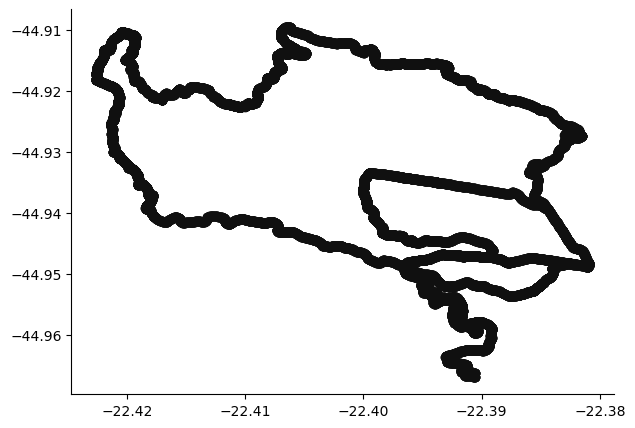

In [21]:
plt.figure(figsize=(7,5))
plt.scatter(df_final['latitude'], df_final['longitude'], color = '#101010')

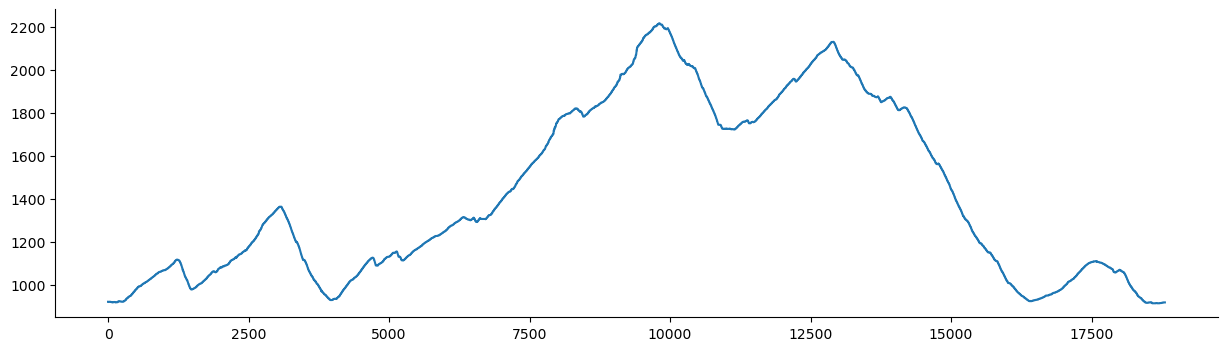

In [22]:
plt.figure(figsize=(15,4))
plt.plot(df_final.index, df_final['elevacao'])

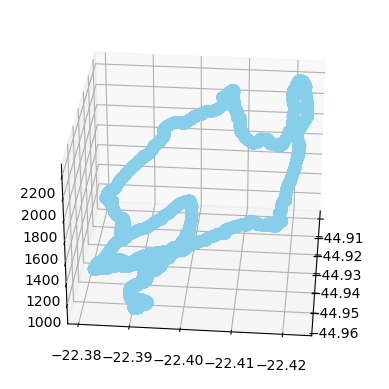

In [23]:
# libraries
from mpl_toolkits.mplot3d import Axes3D


# Dataset
# plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_final['longitude'],df_final['latitude'],  df_final['elevacao'], c='skyblue', s=60)
ax.view_init(30, 185)
plt.show()

In [24]:
import plotly.graph_objects  as  go 

z=df_final['elevacao']
intensity = (z - z.min()) / (z.max() - z.min())

fig = go.Figure(data=[go.Mesh3d(x=df_final['longitude'],
                                y=df_final['latitude'],
                                z=df_final['elevacao'],
                                intensity=intensity,
                                colorbar_title='Elevação',
                                colorscale='Viridis',  # Você pode escolher qualquer escala de cores
                                showscale=True
                                ),
                                go.Scatter3d(
                                    x=df_final['longitude'],
                                    y=df_final['latitude'],
                                    z=df_final['elevacao'],
                                    mode='lines',
                                    line=dict(color='black', width=4),  # Configurações da linha preta
                                    showlegend=False
                                )
])

fig.update_layout(scene=dict(zaxis=dict(range=[z.min(), z.max()])),
                  margin=dict(l=0, r=0, b=0, t=0))
fig.show()

### Análises

Calculando a Diferença de elevação entre os Pontos

In [25]:
df_final['diff_elev'] = df_final['elevacao'].diff()
df_final.head()

C:\Users\joaomm\AppData\Local\Temp\ipykernel_7512\3352394021.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,latitude,longitude,elevacao,diff_elev
0,-22.390529,-44.966182,922.0,NaN
1,-22.390541,-44.966173,922.0,0.0
2,-22.390554,-44.966164,922.0,0.0
3,-22.390574,-44.966155,921.0,-1.0
4,-22.390595,-44.966147,921.0,0.0


Calculando as distancias entre um ponto e outro

In [26]:
def calc_dist(lat1, long1, lat2, long2) -> float:
    distancia = hs.haversine(
        point1 = (lat1, long1),
        point2 = (lat2, long2),
        unit = hs.Unit.METERS
    )
    return np.round(distancia, 2)

In [27]:
distancia = [np.nan]


for i in range(len(df_final)):
    if i == 0:
        continue
    else:
        distancia.append(calc_dist(
            lat1  = df_final.iloc[i-1]['latitude'],
            long1 = df_final.iloc[i-1]['longitude'],
            lat2  = df_final.iloc[i]['latitude'],
            long2 = df_final.iloc[i]['longitude'],
        ))
    
df_final['distancias'] = distancia


C:\Users\joaomm\AppData\Local\Temp\ipykernel_7512\4016835217.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [28]:
df_final.head(10)

,latitude,longitude,elevacao,diff_elev,distancias
0,-22.390529,-44.966182,922.0,NaN,NaN
1,-22.390541,-44.966173,922.0,0.0,1.66
2,-22.390554,-44.966164,922.0,0.0,1.65
3,-22.390574,-44.966155,921.0,-1.0,2.44
4,-22.390595,-44.966147,921.0,0.0,2.44
5,-22.390622,-44.966139,921.0,0.0,3.12
6,-22.390649,-44.966132,921.0,0.0,3.13
7,-22.390681,-44.966123,921.0,0.0,3.63
8,-22.390712,-44.966114,921.0,0.0,3.63
9,-22.390747,-44.966105,921.0,0.0,3.99


In [29]:
df_final.describe()

,latitude,longitude,elevacao,diff_elev,distancias
count,18805.000000,18805.000000,18805.000000,18804.000000,18804.000000
mean,-22.401449,-44.934686,1422.109067,-0.000160,1.915109
std,0.013157,0.015374,404.906001,0.596173,0.926676
min,-22.422615,-44.966801,915.000000,-5.000000,0.050000
25%,-22.415433,-44.947509,1064.000000,0.000000,1.130000
50%,-22.398704,-44.935761,1298.000000,0.000000,1.790000
75%,-22.390824,-44.919905,1816.000000,0.000000,2.650000
max,-22.380926,-44.909499,2217.000000,14.000000,6.360000


In [30]:
df_final['distancias'].sum()

36011.71

- Podemos obter que nosso trajeto tem um total de 36,24km

In [32]:
df_final['soma_elev'] = df_final['diff_elev'].cumsum()
df_final['soma_dist'] = df_final['distancias'].cumsum()
df_final = df_final.fillna(0)
df_final.head()


C:\Users\joaomm\AppData\Local\Temp\ipykernel_7512\1318749434.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\joaomm\AppData\Local\Temp\ipykernel_7512\1318749434.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,latitude,longitude,elevacao,diff_elev,distancias,soma_elev,soma_dist
0,-22.390529,-44.966182,922.0,0.0,0.00,0.0,0.00
1,-22.390541,-44.966173,922.0,0.0,1.66,0.0,1.66
2,-22.390554,-44.966164,922.0,0.0,1.65,0.0,3.31
3,-22.390574,-44.966155,921.0,-1.0,2.44,-1.0,5.75
4,-22.390595,-44.966147,921.0,0.0,2.44,-1.0,8.19


In [33]:
df_final = df_final.reset_index(drop=True)

In [34]:
df_final.describe()

,latitude,longitude,elevacao,diff_elev,distancias,soma_elev,soma_dist
count,18805.000000,18805.000000,18805.000000,18805.000000,18805.000000,18805.000000,18805.000000
mean,-22.401449,-44.934686,1422.109067,-0.000160,1.915007,500.109067,18403.729557
std,0.013157,0.015374,404.906001,0.596157,0.926757,404.906001,9437.148528
min,-22.422615,-44.966801,915.000000,-5.000000,0.000000,-7.000000,0.000000
25%,-22.415433,-44.947509,1064.000000,0.000000,1.130000,142.000000,10813.550000
50%,-22.398704,-44.935761,1298.000000,0.000000,1.790000,376.000000,18415.300000
75%,-22.390824,-44.919905,1816.000000,0.000000,2.650000,894.000000,25555.390000
max,-22.380926,-44.909499,2217.000000,14.000000,6.360000,1295.000000,36011.710000


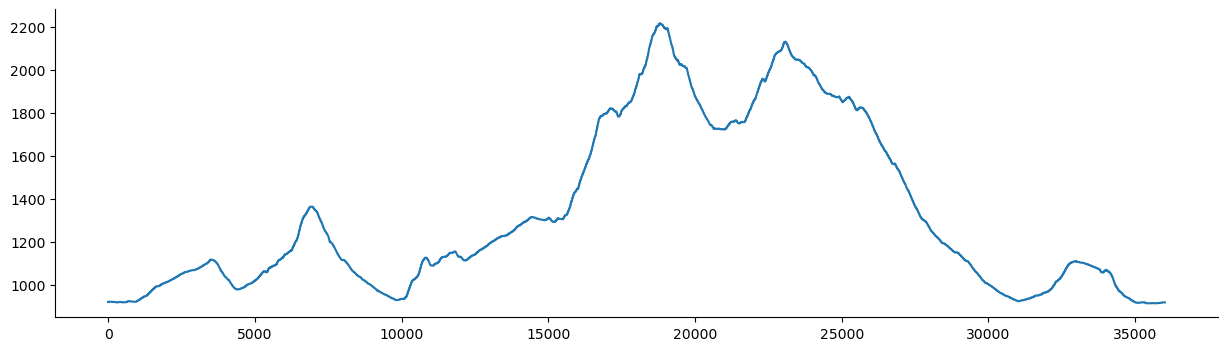

In [35]:
plt.figure(figsize=(15,4))
plt.plot(df_final['soma_dist'], df_final['elevacao'])

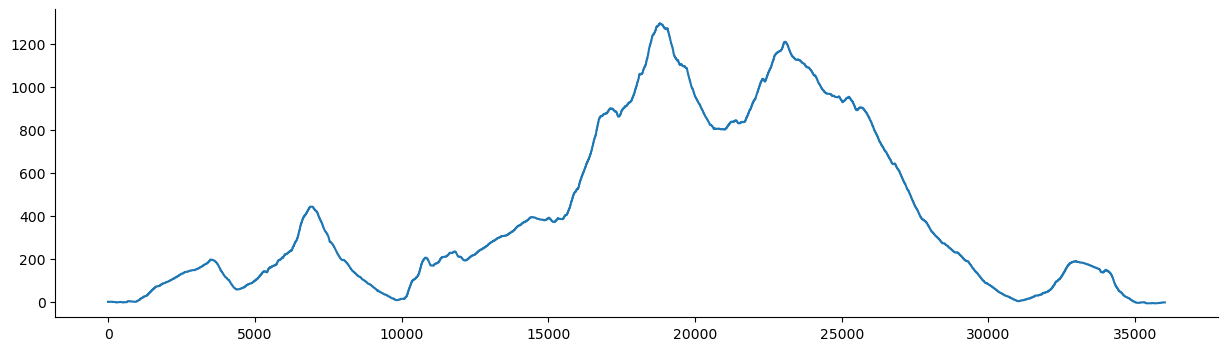

In [36]:
plt.figure(figsize=(15,4))
plt.plot(df_final['soma_dist'], df_final['soma_elev'])

In [37]:
df_final.tail(10)

,latitude,longitude,elevacao,diff_elev,distancias,soma_elev,soma_dist
18795,-22.390746,-44.966757,919.0,0.0,3.12,-3.0,35989.29
18796,-22.390718,-44.966762,919.0,0.0,3.13,-3.0,35992.42
18797,-22.390691,-44.966767,919.0,0.0,3.01,-3.0,35995.43
18798,-22.390665,-44.966772,919.0,0.0,3.02,-3.0,35998.45
18799,-22.390641,-44.966775,919.0,0.0,2.62,-3.0,36001.07
18800,-22.390618,-44.966778,919.0,0.0,2.62,-3.0,36003.69
18801,-22.390600,-44.966780,919.0,0.0,1.97,-3.0,36005.66
18802,-22.390583,-44.966782,919.0,0.0,1.96,-3.0,36007.62
18803,-22.390567,-44.966791,919.0,0.0,2.05,-3.0,36009.67
18804,-22.390551,-44.966801,919.0,0.0,2.04,-3.0,36011.71


In [38]:
df_final.iloc[100:150]

,latitude,longitude,elevacao,diff_elev,distancias,soma_elev,soma_dist
100,-22.392516,-44.964538,920.0,0.0,3.65,-2.0,378.89
101,-22.392547,-44.964533,920.0,0.0,3.52,-2.0,382.41
102,-22.392579,-44.964528,921.0,1.0,3.53,-1.0,385.94
103,-22.392609,-44.964523,921.0,0.0,3.44,-1.0,389.38
104,-22.392640,-44.964517,921.0,0.0,3.45,-1.0,392.83
105,-22.392670,-44.964509,921.0,0.0,3.44,-1.0,396.27
106,-22.392700,-44.964501,921.0,0.0,3.44,-1.0,399.71
107,-22.392729,-44.964489,921.0,0.0,3.48,-1.0,403.19
108,-22.392759,-44.964478,921.0,0.0,3.48,-1.0,406.67
109,-22.392788,-44.964463,921.0,0.0,3.58,-1.0,410.25


In [39]:
import math
df_final['km_group'] = df_final['soma_dist'].apply(lambda x: math.ceil(x / 1000))
df_final.head(20)

,latitude,longitude,elevacao,diff_elev,distancias,soma_elev,soma_dist,km_group
0,-22.390529,-44.966182,922.0,0.0,0.00,0.0,0.00,0
1,-22.390541,-44.966173,922.0,0.0,1.66,0.0,1.66,1
2,-22.390554,-44.966164,922.0,0.0,1.65,0.0,3.31,1
3,-22.390574,-44.966155,921.0,-1.0,2.44,-1.0,5.75,1
4,-22.390595,-44.966147,921.0,0.0,2.44,-1.0,8.19,1
5,-22.390622,-44.966139,921.0,0.0,3.12,-1.0,11.31,1
6,-22.390649,-44.966132,921.0,0.0,3.13,-1.0,14.44,1
7,-22.390681,-44.966123,921.0,0.0,3.63,-1.0,18.07,1
8,-22.390712,-44.966114,921.0,0.0,3.63,-1.0,21.70,1
9,-22.390747,-44.966105,921.0,0.0,3.99,-1.0,25.69,1


In [40]:
# Calcular desnivel_positivo e desnivel_negativo
df_final['desnivel_positivo'] = df_final['diff_elev'].apply(lambda x: x if x > 0 else 0)
df_final['desnivel_negativo'] = df_final['diff_elev'].apply(lambda x: x if x < 0 else 0)


In [41]:
df_final.head(10)

,latitude,longitude,elevacao,diff_elev,distancias,soma_elev,soma_dist,km_group,desnivel_positivo,desnivel_negativo
0,-22.390529,-44.966182,922.0,0.0,0.00,0.0,0.00,0,0.0,0.0
1,-22.390541,-44.966173,922.0,0.0,1.66,0.0,1.66,1,0.0,0.0
2,-22.390554,-44.966164,922.0,0.0,1.65,0.0,3.31,1,0.0,0.0
3,-22.390574,-44.966155,921.0,-1.0,2.44,-1.0,5.75,1,0.0,-1.0
4,-22.390595,-44.966147,921.0,0.0,2.44,-1.0,8.19,1,0.0,0.0
5,-22.390622,-44.966139,921.0,0.0,3.12,-1.0,11.31,1,0.0,0.0
6,-22.390649,-44.966132,921.0,0.0,3.13,-1.0,14.44,1,0.0,0.0
7,-22.390681,-44.966123,921.0,0.0,3.63,-1.0,18.07,1,0.0,0.0
8,-22.390712,-44.966114,921.0,0.0,3.63,-1.0,21.70,1,0.0,0.0
9,-22.390747,-44.966105,921.0,0.0,3.99,-1.0,25.69,1,0.0,0.0


In [42]:
df_final['desnivel_positivo'].sum()

2787.0

In [43]:
# Agrupar por 'km_group' e somar 'desnivel_positivo'
grouped_df = df_final.groupby('km_group')['desnivel_positivo'].sum().reset_index()
grouped_df

,km_group,desnivel_positivo
0,0,0.0
1,1,13.0
2,2,88.0
3,3,58.0
4,4,46.0
5,5,41.0
6,6,128.0
7,7,228.0
8,8,1.0
9,9,1.0


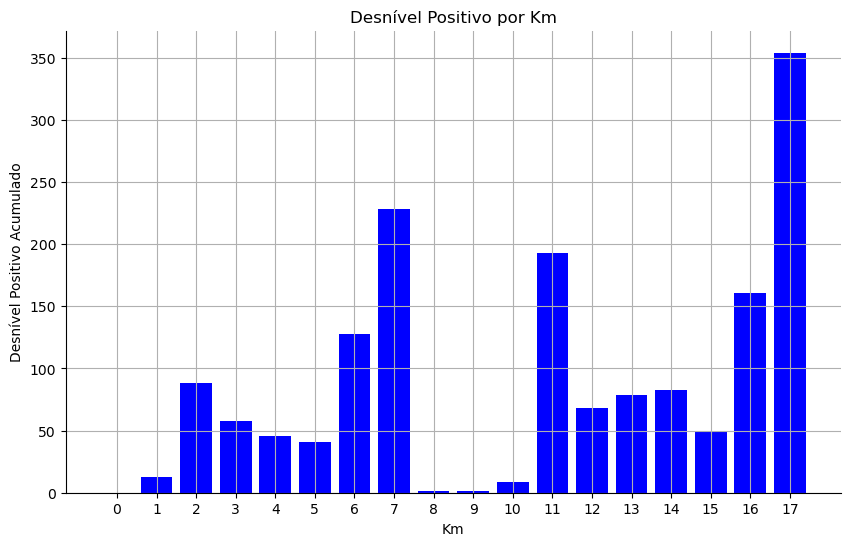

In [44]:
df_filtrado = grouped_df[grouped_df['km_group'] <18 ]
# Plotar o gráfico
plt.figure(figsize=(10, 6))
plt.bar(df_filtrado['km_group'], df_filtrado['desnivel_positivo'], color='b')
plt.xlabel('Km')
plt.ylabel('Desnível Positivo Acumulado')
plt.title('Desnível Positivo por Km')
plt.xticks(df_filtrado['km_group'])
plt.grid(True)
plt.show()

In [45]:
# Calcular o 'desnivel_positivo' acumulado
grouped_df['desnivel_positivo_acumulado'] = grouped_df['desnivel_positivo'].cumsum()
grouped_df

,km_group,desnivel_positivo,desnivel_positivo_acumulado
0,0,0.0,0.0
1,1,13.0,13.0
2,2,88.0,101.0
3,3,58.0,159.0
4,4,46.0,205.0
5,5,41.0,246.0
6,6,128.0,374.0
7,7,228.0,602.0
8,8,1.0,603.0
9,9,1.0,604.0


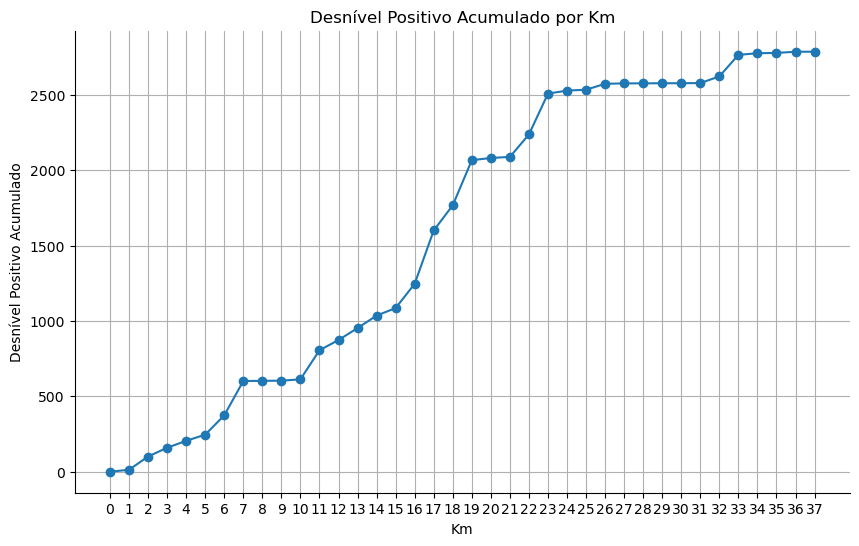

In [46]:
# Plotar o gráfico
plt.figure(figsize=(10, 6))
plt.plot(grouped_df['km_group'], grouped_df['desnivel_positivo_acumulado'], marker='o', linestyle='-')
plt.xlabel('Km')
plt.ylabel('Desnível Positivo Acumulado')
plt.title('Desnível Positivo Acumulado por Km')
plt.xticks(grouped_df['km_group'])
plt.grid(True)
plt.show()

In [40]:
df_final['desnivel_negativo'].sum()

-3001.134883250961

In [47]:
df_final.to_csv("tabela_final_lsmision_35km_ultima.csv", sep = ';')